# Seasonality analysis

In [15]:
import os
import datetime as dt
import pickle


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
# symbol = '^GSPC'      # S&P 500
# symbol = 'AAPL'       # Apple




# set maximum number of years to analyze
max_num_of_years = 5



# set number of days for rolling averages for full data plots
rolling_narrow_resolution = 50
rolling_wide_resolution = 200



# set number of day of rolling averages for annual data plots
annualRollingDays = 20


# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: ALV.DE

* **Max years to analyse**: 2022 until earliest 2018

In [16]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"
pickleFilename = f"{dirname}{os.path.sep}lastAnalysis.pkl"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
#df = ticker.history(period='max')

dataDownloaded = False

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")
    df.to_csv(historyFilename)
    dataDownloaded = True
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])

df = df[['Close']]


D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')
D(f'* Downloaded from internet: {dataDownloaded}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')


# set correct frequency
df = df.asfreq('B')

# fill up missing values
df = df.fillna(method='ffill')



D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _ALV.DE_

* From 16.12.96 to 18.08.23

* Downloaded from internet: False

## Statistics:

             Close
count  6960.000000
mean    167.813576
std      80.160391
min      45.400002
25%     102.084997
50%     152.525002
75%     208.412495
max     441.160004


## Data:

                 Close
Date                  
1996-12-16  144.158997
1996-12-17  141.526001
1996-12-18  140.656006
1996-12-19  140.093994
1996-12-20  141.473999
...                ...
2023-08-14  224.300003
2023-08-15  221.250000
2023-08-16  221.750000
2023-08-17  221.949997
2023-08-18  221.149994

[6960 rows x 1 columns]


In [17]:
# prepare range of max 5 years or smaller if dataframe is smaller
firstDay = pd.to_datetime(str((df.index.year.min()+1 if ((df.index.year.max()-1) - (df.index.year.min()+1)) < max_num_of_years else df.index.year.max() - max_num_of_years)) + '-01-01')
lastDay = pd.to_datetime(str(df.index.year.max()-1) + '-12-31')
rangeMax5yrs = pd.date_range(firstDay, lastDay, freq='D')

# get actual number of calculated years for dataframe
rangeNumOfYears = rangeMax5yrs.max().year - rangeMax5yrs.min().year + 1

# save information for backtrader
backtestInfo = {
    'historyFilename': historyFilename,
    'rangeMax5yrs' : rangeMax5yrs,
}
pickle.dump(backtestInfo, open(pickleFilename, 'wb'))

# Prepare new dataframe in long form for annual data distribution
def dfToAnnualLongForm(inputDf):
    # Create new dataframe
    annualDf = pd.DataFrame(data=inputDf)

    # set correct frequency for better comparison
    annualDf = annualDf.asfreq('d')

    # fill up missing values for better comparison
    annualDf = annualDf.fillna(method='ffill')

    # Drop Feb. 29th of leap years for better comparison
    annualDf = annualDf[~((annualDf.index.month == 2) & (annualDf.index.day == 29))] 

    # Create year and day/month columns
    annualDf['Year'], annualDf['Day'] = annualDf.index.year, annualDf.index.strftime('%m-%d')

    # crop dataframe to max 5 last full years
    annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()]
    
    # remove date index and return to numbered index
    annualDf = annualDf.reset_index()
    
    # remove date column which was left over from removing date index
    annualDf = annualDf.drop('Date', axis=1)
    
    # set to multiindex: 1st level 'Day', 2nd level 'Year'
    annualDf = annualDf.set_index(['Year', 'Day'])
    
    # reorder by index level 'Day'
    annualDf = annualDf.sort_index(level='Year')

    return annualDf

annualDf = dfToAnnualLongForm(df.assign(**{'rolling average': df['Close'].rolling(annualRollingDays).mean()}))

D('## Initial data overview')
annualDf
#annualDf.index


## Initial data overview

Close  rolling average
Year Day                               
2018 01-01  191.500000       196.347500
     01-02  192.699997       196.047500
     01-03  193.000000       195.747500
     01-04  195.500000       195.602500
     01-05  198.559998       195.573000
...                ...              ...
2022 12-27  203.050003       202.561999
     12-28  202.149994       202.451998
     12-29  203.699997       202.449498
     12-30  200.899994       202.361998
     12-31  200.899994       202.361998

[1825 rows x 2 columns]

In [18]:
#periodNames = ['seasonal_' + str(i) for i in periods]

decompDf = pd.DataFrame(data=df)

# crop dataframe to max 5 last full years
decompDf = decompDf[rangeMax5yrs.min():pd.to_datetime('today')]

# prepare the 3 dataframes for seasonal, trend and residual
seasonalDecompDf = pd.DataFrame()
trendDecompDf = pd.DataFrame()
residDecompDf = pd.DataFrame()

# simplest form of STL
decomposeSimpleStl = STL(decompDf['Close'], period=365)
decomposeSimpleRes = decomposeSimpleStl.fit()

seasonalDecompDf['Simple STL'] = decomposeSimpleRes.seasonal
trendDecompDf['Simple STL'] = decomposeSimpleRes.trend
residDecompDf['Simple STL'] = decomposeSimpleRes.resid

# simplest form of STL
decomposeRobustStl = STL(decompDf['Close'], period=365, robust=True)
decomposeRobustRes = decomposeSimpleStl.fit()

seasonalDecompDf['Robust STL'] = decomposeRobustRes.seasonal
trendDecompDf['Robust STL'] = decomposeRobustRes.trend
residDecompDf['Robust STL'] = decomposeRobustRes.resid

# prepare annual dataframes with multiindex including the rolling averages
annunalSeasonalDecompDf = dfToAnnualLongForm(seasonalDecompDf.assign(**{'rolling average': seasonalDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))
annunalTrendDecompDf = dfToAnnualLongForm(trendDecompDf.assign(**{'rolling average': trendDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))
annunalResidDecompDf = dfToAnnualLongForm(residDecompDf.assign(**{'rolling average': residDecompDf['Simple STL'].rolling(annualRollingDays).mean()}))

#pd.set_option('display.max_rows', None)

D('## Seasonal decomposition')
print(seasonalDecompDf)
print(annunalSeasonalDecompDf)

## Seasonal decomposition

            Simple STL  Robust STL
Date                              
2018-01-01    9.199650    9.199650
2018-01-02    9.580899    9.580899
2018-01-03    7.793383    7.793383
2018-01-04    9.919449    9.919449
2018-01-05   11.447374   11.447374
...                ...         ...
2023-08-14   18.825478   18.825478
2023-08-15   16.923263   16.923263
2023-08-16   16.199118   16.199118
2023-08-17   16.173892   16.173892
2023-08-18   15.644743   15.644743

[1470 rows x 2 columns]
            Simple STL  Robust STL  rolling average
Year Day                                           
2018 01-01    9.199650    9.199650              NaN
     01-02    9.580899    9.580899              NaN
     01-03    7.793383    7.793383              NaN
     01-04    9.919449    9.919449              NaN
     01-05   11.447374   11.447374              NaN
...                ...         ...              ...
2022 12-27    0.828002    0.828002         3.839707
     12-28   -0.563531   -0.563531         3.503197


In [19]:
# Prepare new dataframe in long form for monthly categorial data
def dfToMonthlyLongForm(inputDf):
    # Create new dataframe
    annualDf = pd.DataFrame(data=inputDf)

    # set correct frequency for better comparison
    annualDf = annualDf.asfreq('M')

    # fill up missing values for better comparison
    annualDf = annualDf.fillna(method='ffill')

    # Create year and day/month columns
    annualDf['Year'], annualDf['Month'] = annualDf.index.year, annualDf.index.strftime('%B')

    # crop dataframe to max 5 last full years
    annualDf = annualDf[rangeMax5yrs.min():rangeMax5yrs.max()]
    
    # remove date index and return to numbered index
    annualDf = annualDf.reset_index()
    
    # remove date column which was left over from removing date index
    annualDf = annualDf.drop('Date', axis=1)
    
    return annualDf


monthlySeasonalDecompDf = dfToMonthlyLongForm(seasonalDecompDf.resample('M').mean())
monthlySeasonalDecompDf.head()

,Simple STL,Robust STL,Year,Month
0,18.793358,18.793358,2018,January
1,16.130881,16.130881,2018,February
2,7.337984,7.337984,2018,March
3,11.692221,11.692221,2018,April
4,14.149504,14.149504,2018,May


In [20]:
# setup general figure size
generalPlotWidth = 15
generalSubPlotHight = 5

# activate retina mode
plt.rcParams['figure.dpi'] = 200

# configure theme and style
sns.set_theme('paper')
sns.set_style('darkgrid')


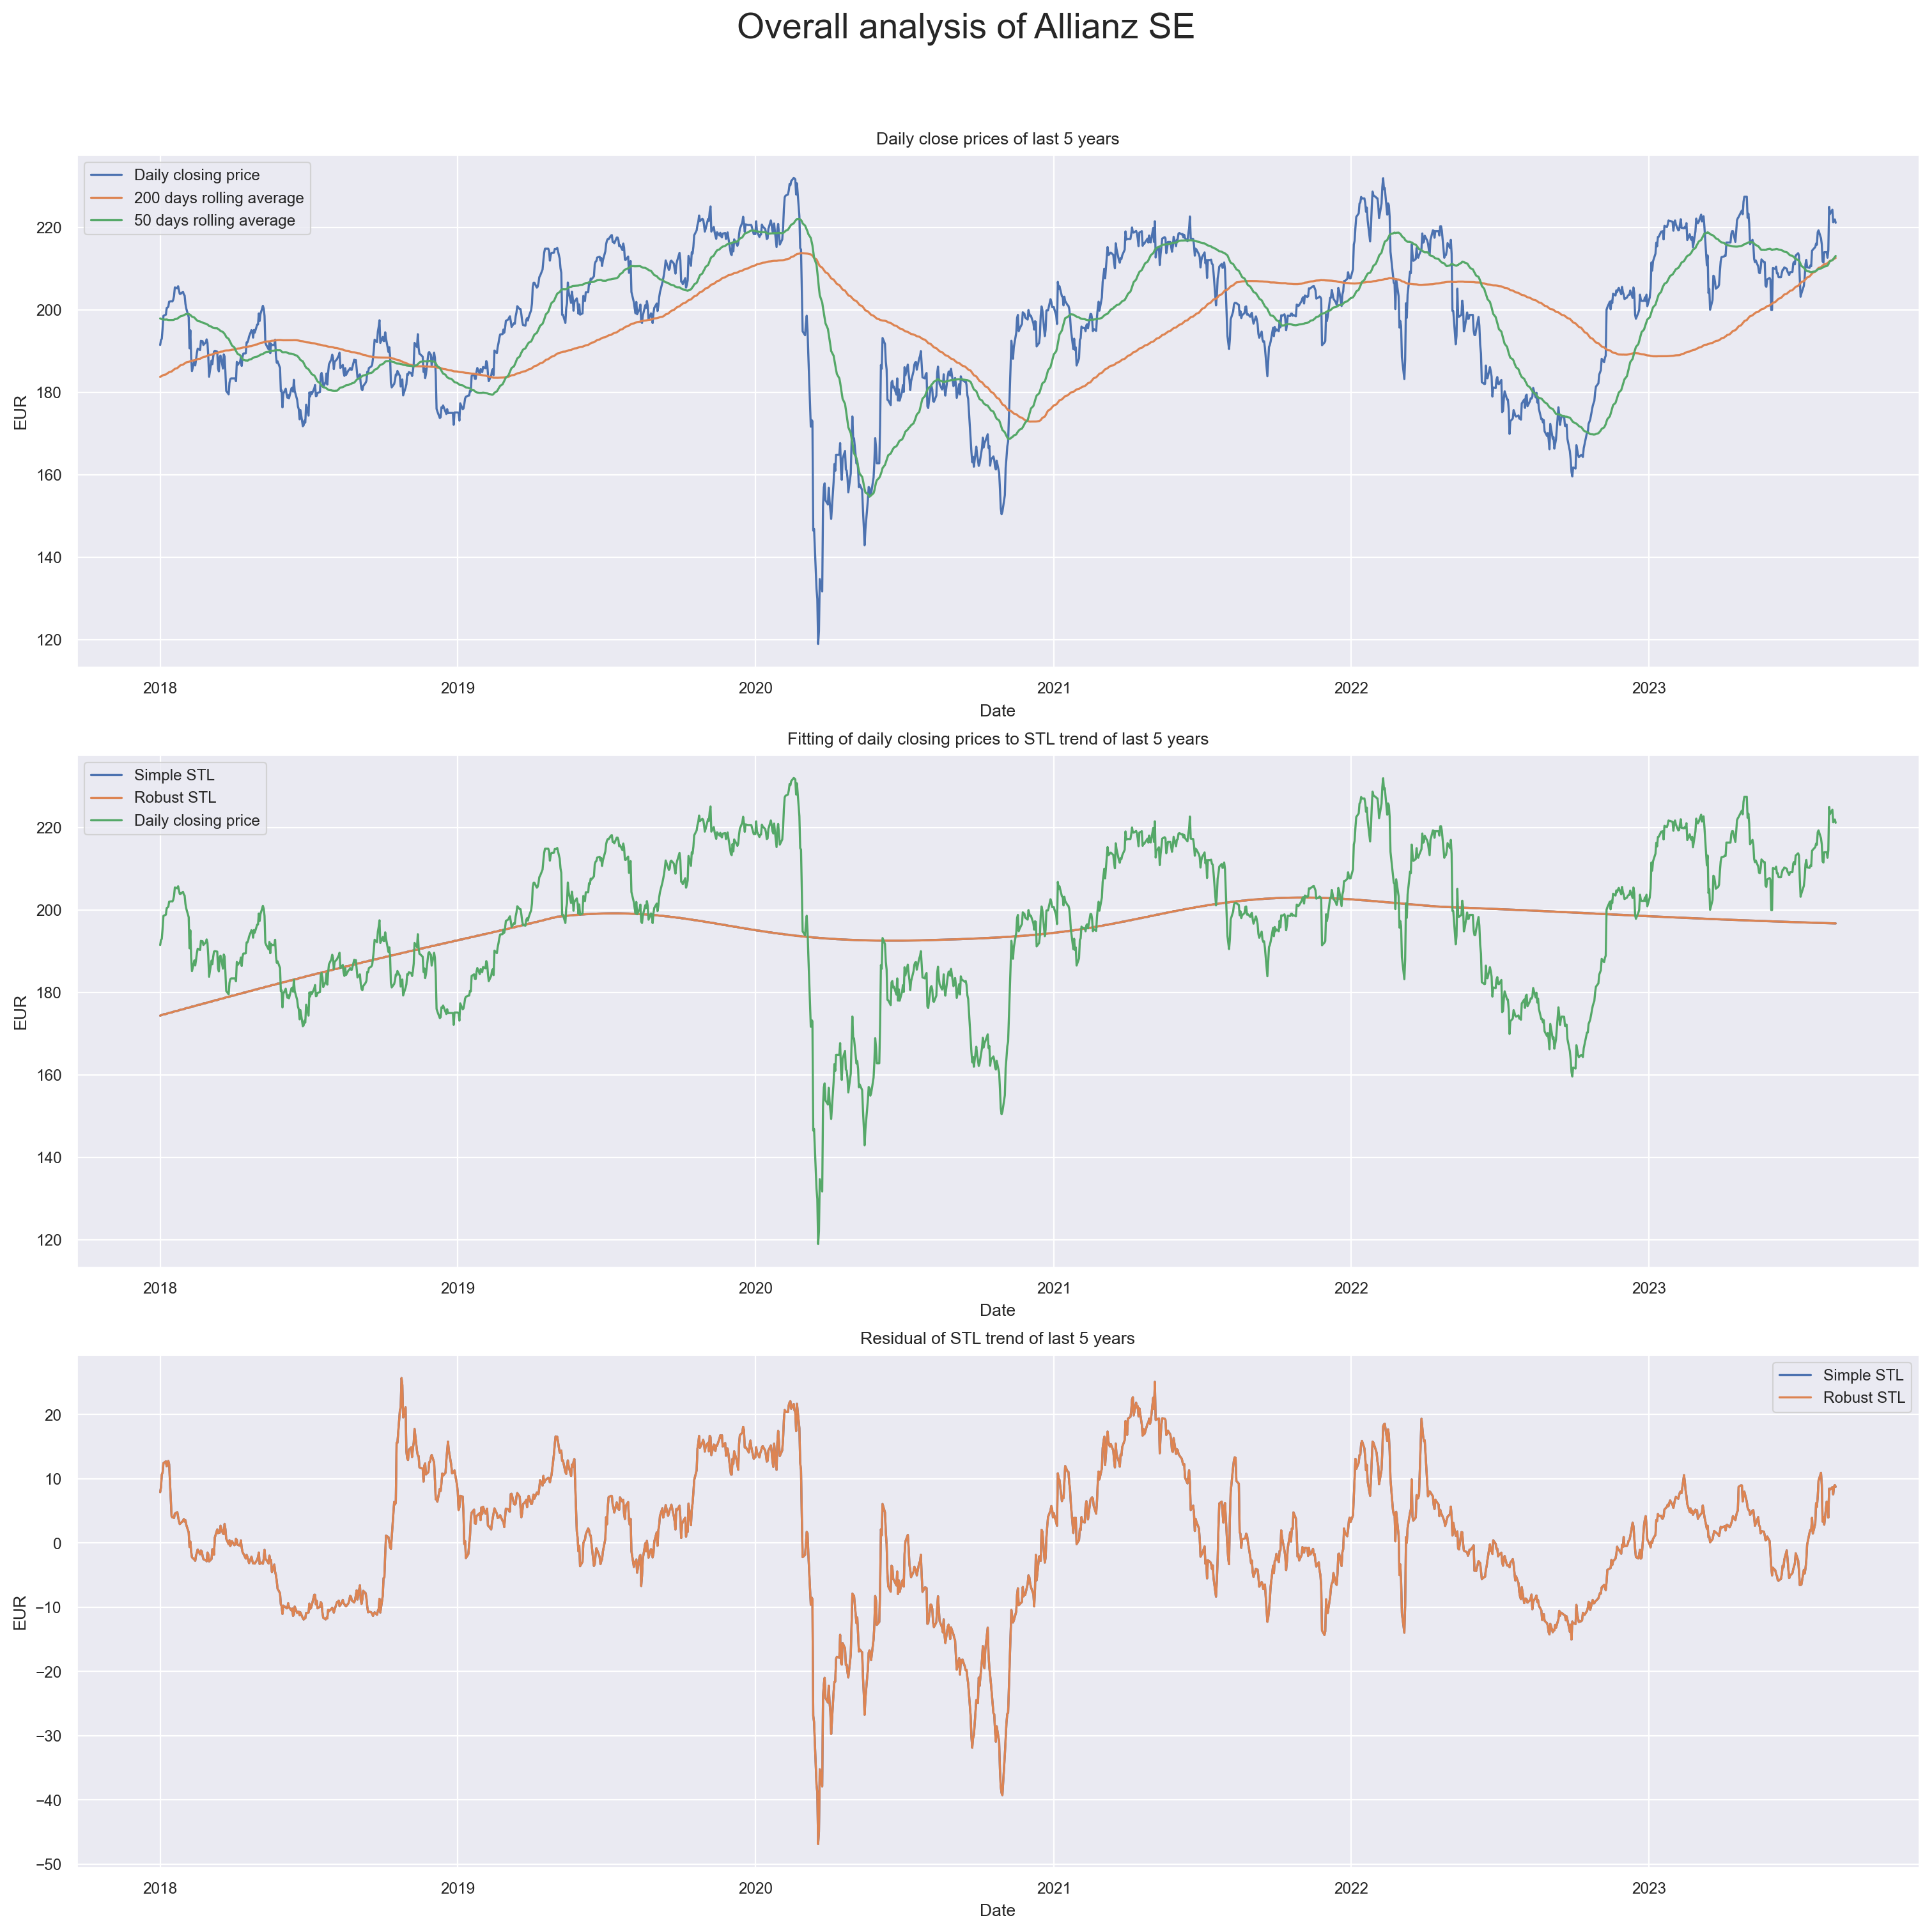

In [21]:

numSubPlots = 3
fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
fig.suptitle(f'Overall analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot overall closing prices of last x years
overallDf = pd.DataFrame(data=df)
overallDf[f'{rolling_wide_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_wide_resolution).mean()
overallDf[f'{rolling_narrow_resolution} days rolling average'] = overallDf['Close'].rolling(rolling_narrow_resolution).mean()
overallDf.rename(columns={'Close':'Daily closing price'}, inplace=True)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Daily close prices of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall closing prices of last x years with STL trend
overallDf = pd.DataFrame(data=trendDecompDf)
overallDf = overallDf[rangeMax5yrs.min():pd.to_datetime('today')]
overallDf['Daily closing price'] = df[rangeMax5yrs.min():pd.to_datetime('today')]['Close']
sns.lineplot(data=overallDf, dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Fitting of daily closing prices to STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1


# Plot overall STL residual of last x years with STL trend
overallDf = pd.DataFrame(data=residDecompDf)
sns.lineplot(data=overallDf[['Simple STL', 'Robust STL']], dashes=False, ax=axs[currentAxis], legend='full')
axs[currentAxis].set_title(f'Residual of STL trend of last {rangeNumOfYears} years')
axs[currentAxis].set_ylabel(ticker.info['currency'])
currentAxis += 1

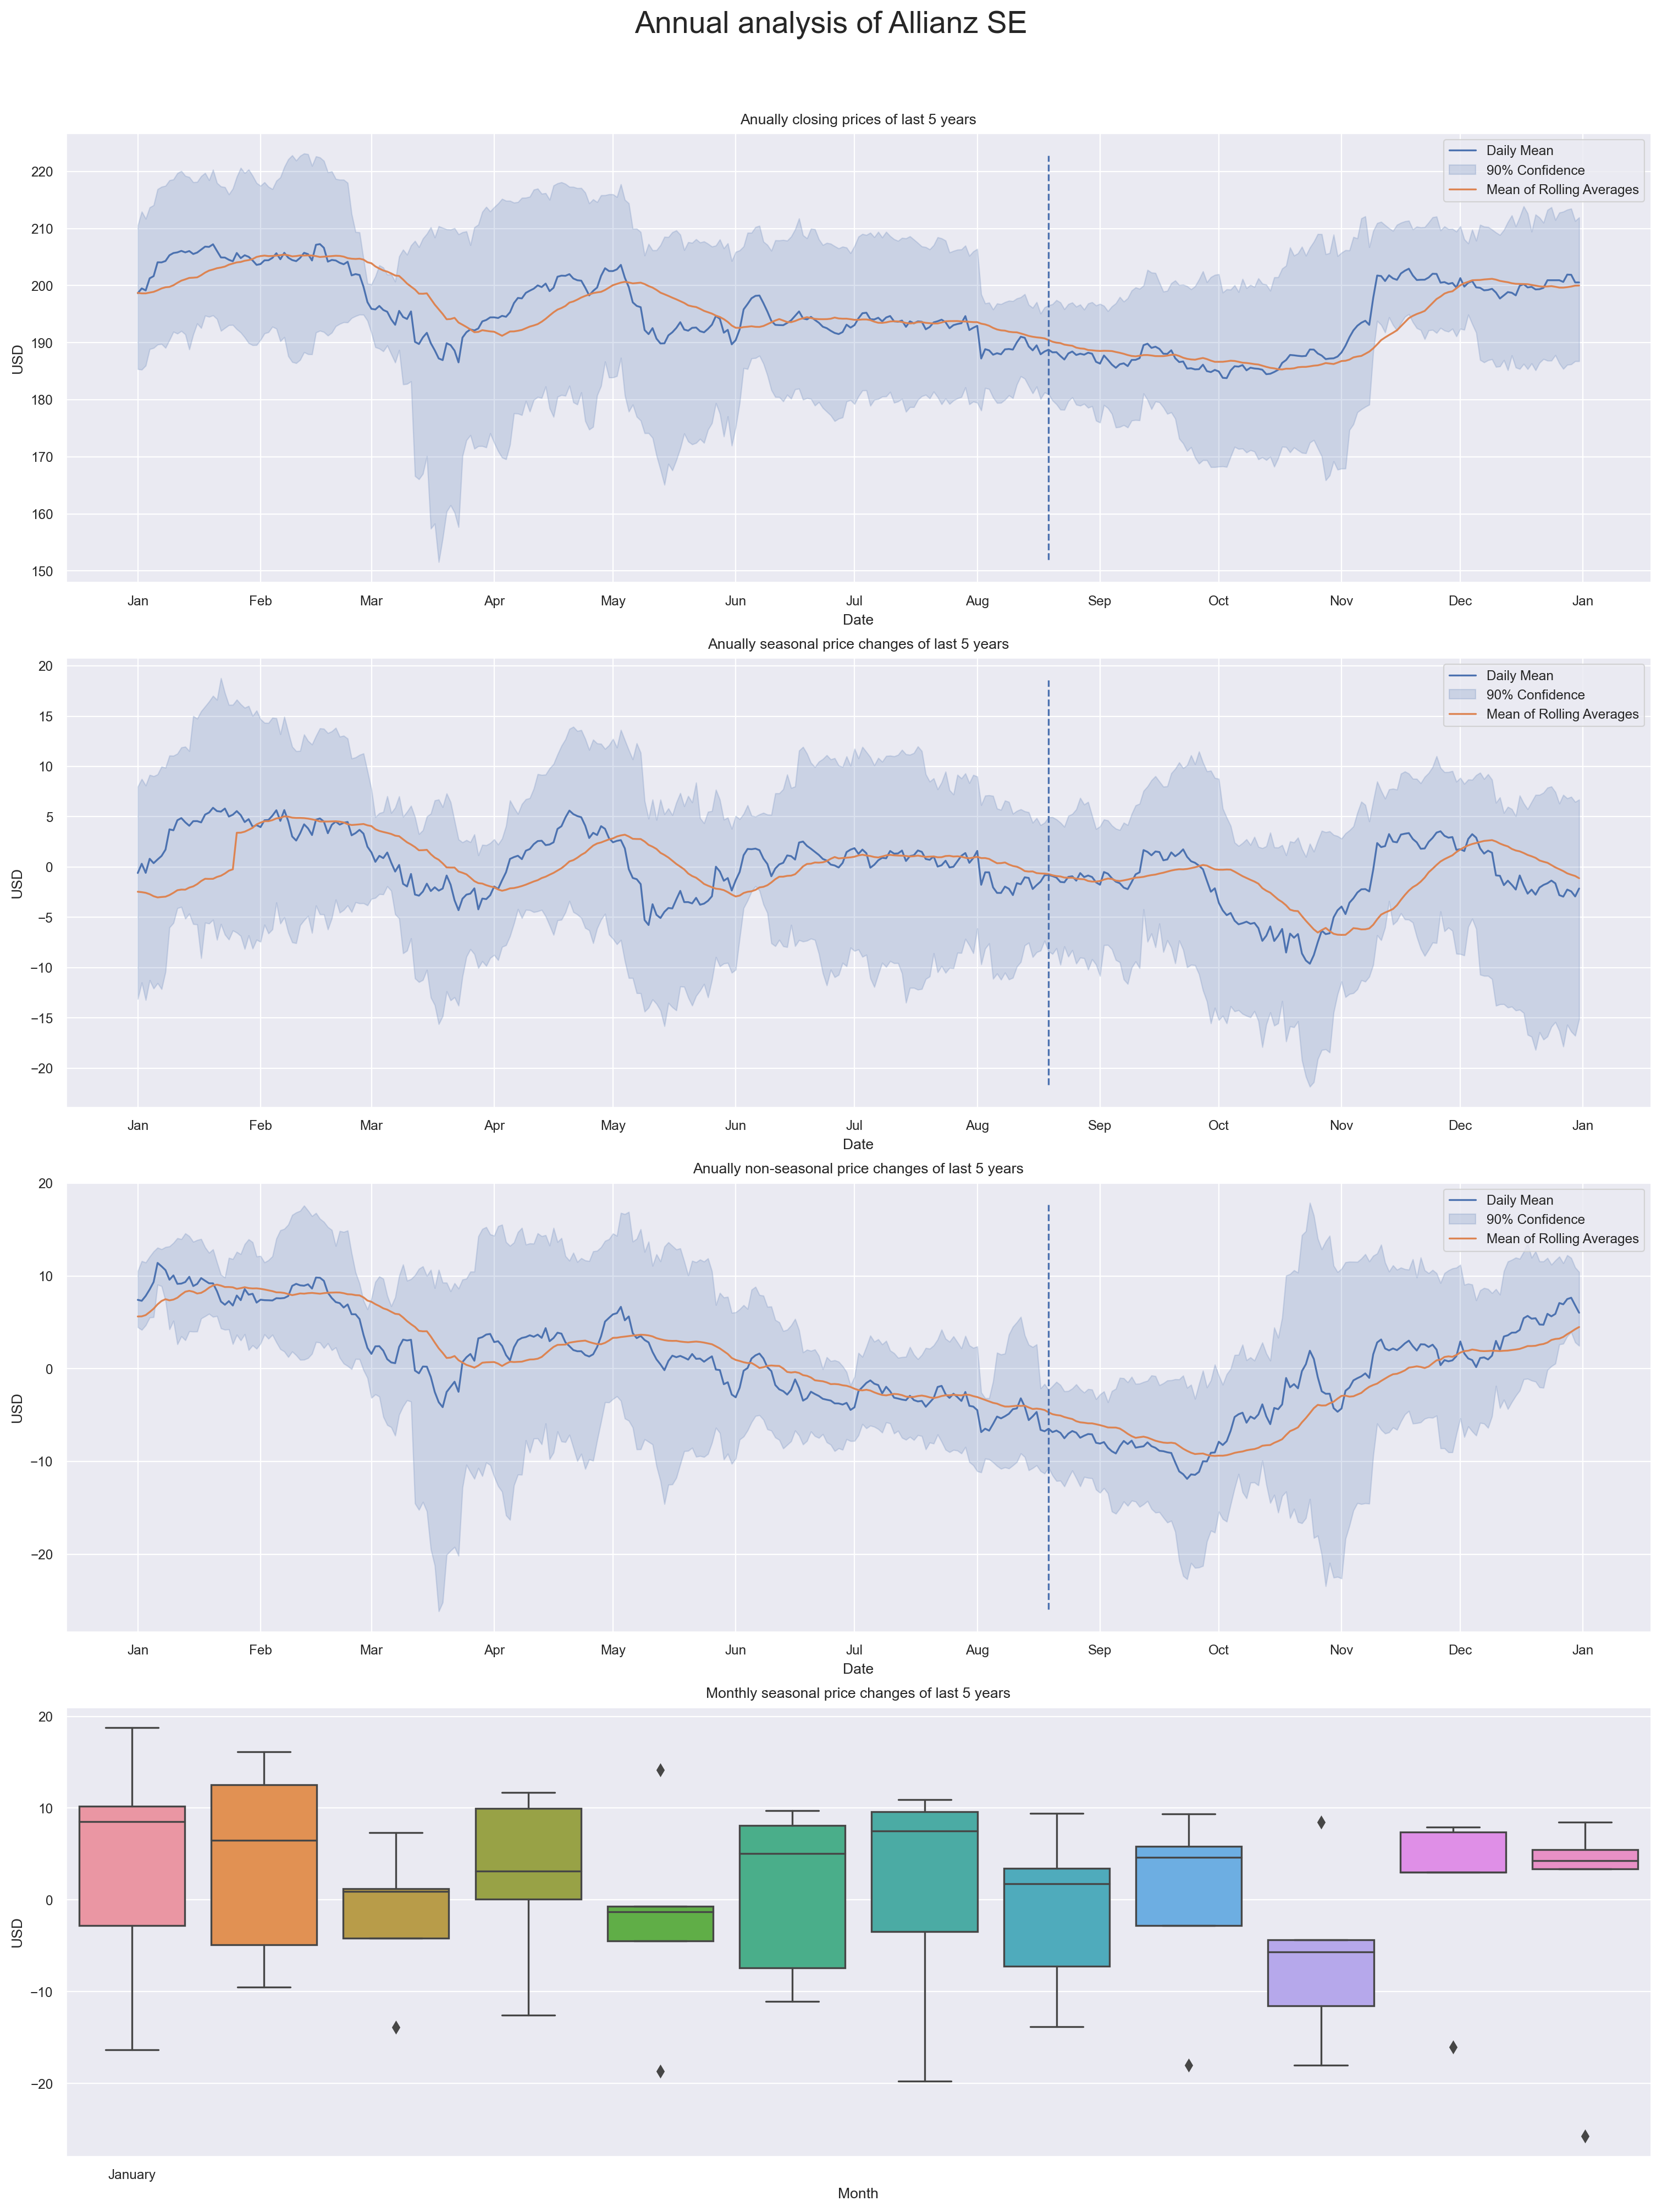

In [22]:
numSubPlots = 4

fig, axs = plt.subplots(numSubPlots, 1, figsize=(generalPlotWidth, generalSubPlotHight*numSubPlots), layout="constrained")
sns.set_theme('paper')
fig.suptitle(f'Annual analysis of {ticker.info["longName"]}\n\n', fontsize=20)

currentAxis = 0

# Plot annual closing prices with confidence band
sns.lineplot(data=annualDf, x='Day', y='Close', ax=axs[currentAxis], sort=True)
sns.lineplot(data=annualDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually closing prices of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


# Plot annual seasonal prices with confidence band
#        if seasonalityInPercent:
#            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
#        else:
#            usedAnnualDf = annualDf[col]
sns.lineplot(data=annunalSeasonalDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalSeasonalDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)
axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


# Plot annual residual prices with confidence band
sns.lineplot(data=annunalResidDecompDf, ax=axs[currentAxis], x='Day', y='Simple STL')
sns.lineplot(data=annunalResidDecompDf, x='Day', y='rolling average', ax=axs[currentAxis], sort=True, errorbar=None)

axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Date')
axs[currentAxis].set_title(f'Anually non-seasonal price changes of last {rangeNumOfYears} years')
axs[currentAxis].legend(labels=['Daily Mean', '90% Confidence', 'Mean of Rolling Averages'])
axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1


# Plot monthly seasonal prices with confidence band
sns.boxplot(data=monthlySeasonalDecompDf, x='Month', y='Simple STL', ax=axs[currentAxis])

axs[currentAxis].xaxis.set_major_locator(mdates.MonthLocator())
#axs[currentAxis].axvline(f'{"{:02d}".format(dt.date.today().month)}-{"{:02d}".format(dt.date.today().day)}', ymin=0.05, ymax=0.95, linestyle='dashed')
axs[currentAxis].set_ylabel('USD')
axs[currentAxis].set_xlabel('Month')
axs[currentAxis].set_title(f'Monthly seasonal price changes of last {rangeNumOfYears} years')
#axs[currentAxis].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
currentAxis += 1